# Rhme2 hard SCA challenge in Jlsca

Requires:

* The 305 MB traceset tarball from https://drive.google.com/open?id=0B2slHLSL3nXaOHdhTXpMMHZkNjQ. Uncompress it next to this notebook.
* Jlsca, PyCall and PyPlot packages
* IJulia package

In [1]:
# load the packages

using Jlsca.Sca
using Jlsca.Trs
using Jlsca.Align
using PyCall
using PyPlot.plot

@pyimport numpy

## Convert traces from Chipwhisperer capture to Trs format

In [5]:
# prefix identifying the capture, bulky as it is
# (so far have been lazy to automate based on ChipWhisperer config file)
prefix = "hardsca_longer_traces/2017.01.27-17.45.58_"

samples = numpy.load("$(prefix)traces.npy");
input = numpy.load("$(prefix)textin.npy");
output = numpy.load("$(prefix)textout.npy");

numberOfTraces = size(input)[1] # because it happens that CW software saves more traces then inputs o_O
numberOfSamples = size(samples)[2]
dataSpace = size(input)[2] + size(output)[2]
sampleType = Float32;

In [6]:
trs = InspectorTrace("hardsca_longer_traces.trs", dataSpace, sampleType, numberOfSamples)
for t in 1:numberOfTraces
  trs[t] = (vcat(input[t,:],output[t,:]), map(Float32, samples[t,:]))
end
close(trs)

Creating Inspector trs file hardsca_longer_traces.trs
#samples: 24400
#data:    32
type:     Float32
Wrote 10000 traces in hardsca_longer_traces.trs


## Explore traces

In [3]:
trs = InspectorTrace("hardsca_longer_traces.trs")

Opened hardsca_longer_traces.trs, #traces 10000, #samples 24400 (Float32), #data 32


Jlsca.Trs.InspectorTrace(0x00,Nullable{Int64}(10000),0x0020,4,Float32,0x00005f50,24,IOStream(<file hardsca_longer_traces.trs>),Any[],Any[],Union,Union,0,"hardsca_longer_traces.trs",24,false,18,false)

In [4]:
((data,samples),eof) = readTraces(trs, 1:10)

((
UInt8[0xd4 0xa7 … 0x0b 0xd6; 0x47 0x38 … 0x37 0xf9; … ; 0xff 0x4a … 0x40 0xc6; 0xc2 0xc3 … 0x1d 0xeb],

Float32[0.137695 0.108398 … 0.0908203 0.167969; 0.0166016 -0.30957 … 0.204102 0.119141; … ; 0.178711 -0.00878906 … -0.00390625 -0.124023; 0.0429688 0.0830078 … -0.373047 -0.109375]),false)

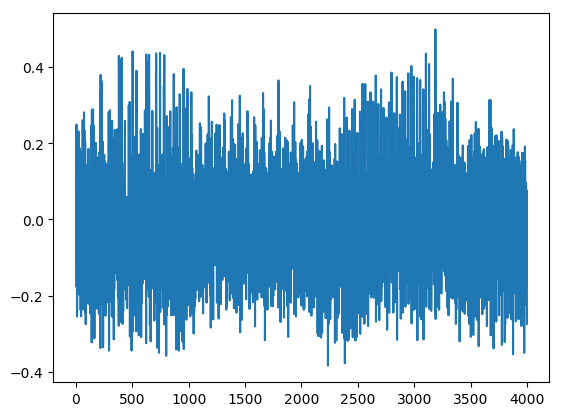

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x325033c50>

In [5]:

plot(samples[3,18000:22000])

## CPA attack with alignment

In [ ]:
# load extra stuff
import Jlsca.Sca.FORWARD,Jlsca.Sca.BACKWARD,Jlsca.Sca.PHASE1,Jlsca.Sca.PHASE2,Jlsca.Sca.SBOX,Jlsca.Sca.ROUNDOUT
import Base.sync_begin, Base.sync_end, Base.async_run_thunk

In [ ]:
params = AesSboxAttack()
params.dataOffset = 17
params.direction = BACKWARD
params.analysis = DPA()
params.analysis.statistic = cor
params.analysis.leakageFunctions = [hw]

numberOfAverages = length(params.keyByteOffsets)
numberOfCandidates = getNumberOfCandidates(params)

In [ ]:
  @everyworker begin
      trs = InspectorTrace("traces_rhme2/hardsca_longer_traces.trs")

      maxShift = 20000
      referenceOffset = 5000
      reference = trs[1][2][referenceOffset:referenceOffset+5000]
      corvalMin = 0.4
      alignstate = CorrelationAlignFFT(reference, referenceOffset, maxShift)
      addSamplePass(trs, x -> ((shift,corval) = correlationAlign(x, alignstate); corval > corvalMin ? circshift(x, shift) : Vector{eltype(x)}(0)))

      setPostProcessor(trs, CondAvg(SplitByData($numberOfAverages, $numberOfCandidates)))
  end
  numberOfTraces = @fetch length(Main.trs)
  sca(DistributedTrace(), params, 1, numberOfTraces, false)

In [ ]:
using PyPlot.plot

In [ ]:
popDataPass(trs)

In [ ]:
((data,samples),eof) = readTraces(trs, 1:10)